In [3]:
import pickle
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.frame import DataFrame

## example

```bash
nohup parallel 'python3 experiment_dbpedia_14.py --group_id dbpedia_14_20240109 --n_sample_from 5 --n_sample_to 25 --n_trials 10 --verification {1} --strategy {2}' ::: themselves dataset ::: normal super > results/ex_20240109.log &

In [4]:
group_id = "truthfulqa_20240202"

# load result
result_files = glob.glob(f"./results/{group_id}/*.pickle")
results = []
for file in result_files:
    with open(file, "rb") as f:
        tmp = pickle.load(f)
        # print("verification: ", tmp["args"].verification)
        # print("strategy: ", tmp["args"].strategy)
        if tmp["args"].verification == "themselves" and tmp["args"].strategy == "normal":
            results.append(tmp)

# create plots folder
os.makedirs(f"./plots/{group_id}/", exist_ok=True)

print(results[0]["result"])

[[{'class label': 'Geography', 'TP': 5, 'TN': 0, 'FP': 0, 'FN': 5, 'precision': 1.0, 'negative examples': ['apple', 'banana', 'orange', 'grape', 'strawberry'], 'positive examples': ['mountain', 'river', 'ocean', 'desert', 'forest'], 'accuracy': 0.5, 'n_samples': 5}, {'class label': 'Vacation policies', 'TP': 1, 'TN': 0, 'FP': 4, 'FN': 5, 'precision': 0.2, 'negative examples': ['apple', 'banana', 'cherry', 'durian', 'elderberry'], 'positive examples': ['Unlimited PTO', 'Accrued PTO', 'Paid Time Off', 'Sick Leave', 'Parental Leave'], 'accuracy': 0.1, 'n_samples': 5}, {'class label': ' Inspiration', 'TP': 0, 'TN': 0, 'FP': 5, 'FN': 5, 'precision': 0.0, 'negative examples': ['apple', 'banana', 'orange', 'grape', 'strawberry'], 'positive examples': ['The Alchemist', 'To Kill a Mockingbird', 'Pride and Prejudice', '1984', 'The Great Gatsby'], 'accuracy': 0.0, 'n_samples': 5}, {'class label': ' Geography', 'TP': 5, 'TN': 0, 'FP': 0, 'FN': 5, 'precision': 1.0, 'negative examples': ['apple', 'b

In [5]:
# make results into dataframe
df_columns = ["model", "label", "accuracy", "precision", "TP", "TN", "FP", "FN", "n_samples", "n_trials", "strategy"]
df_data = []
time_elapsed = 0
ex_id = ""
args = {}
for r in results:
    # when different args, display it
    if args != r["args"]:
        print("#data: ", len(df_data))
        print("experiment settings: ", r["args"])
    args = r["args"]
    n_trials = args.n_trials
    max_retry = args.max_retry
    model = args.model
    strategy = args.strategy
    # if args.verification == "themselves" or strategy == "normal":
    #     continue
    for trial in r["result"]:
        for sample in trial:
            df_data.append([
                model,
                sample["class label"],
                sample["accuracy"],
                sample["precision"],
                sample["TP"],
                sample["TN"],
                sample["FP"],
                sample["FN"],
                sample["n_samples"],
                n_trials,
                strategy,
            ])
    time_elapsed = int(r["finish_time"]) - int(r["start_time"])
    ex_id = r["experiment_id"]
df_results = pd.DataFrame(df_data, columns=df_columns)
print("---")
print("time elapsed: ", time_elapsed)
print("experiment id: ", ex_id)
print("#data: ", len(df_data))
# print("total #data should be:", 14*n_trials*5)
print(df_results.loc[0:14].to_latex(escape=True))

#data:  0
experiment settings:  Namespace(group_id='truthfulqa_20240202', n_trials=1, n_sample_from=5, n_sample_to=25, n_sample_step=5, model='gpt-3.5-turbo-instruct-0914', logging=True, max_retry=3, test=False, strategy='normal', verification='themselves', temperature=0.0, n_items=0)
---
time elapsed:  15466
experiment id:  ea805dea78d4c315e7a260dae98d211a
#data:  2535
\begin{tabular}{lllrrrrrrrrl}
\toprule
 & model & label & accuracy & precision & TP & TN & FP & FN & n\_samples & n\_trials & strategy \\
\midrule
0 & gpt-3.5-turbo-instruct-0914 & Geography & 0.500000 & 1.000000 & 5 & 0 & 0 & 5 & 5 & 1 & normal \\
1 & gpt-3.5-turbo-instruct-0914 & Vacation policies & 0.100000 & 0.200000 & 1 & 0 & 4 & 5 & 5 & 1 & normal \\
2 & gpt-3.5-turbo-instruct-0914 &  Inspiration & 0.000000 & 0.000000 & 0 & 0 & 5 & 5 & 5 & 1 & normal \\
3 & gpt-3.5-turbo-instruct-0914 &  Geography & 0.500000 & 1.000000 & 5 & 0 & 0 & 5 & 5 & 1 & normal \\
4 & gpt-3.5-turbo-instruct-0914 & Material science & 0.40000

In [6]:
# group by n_sample
res_g_sample = df_results.groupby(by=["n_samples"], as_index=False).mean(["accuracy", "precision"])

cor = res_g_sample[['n_samples', 'accuracy', 'precision']].corr()

res_g_sample = res_g_sample.drop(columns=["n_trials"])

print(res_g_sample.to_latex(escape=True,index=False))


print(cor.to_latex(escape=True))

\begin{tabular}{rrrrrrr}
\toprule
n\_samples & accuracy & precision & TP & TN & FP & FN \\
\midrule
5 & 0.390533 & 0.753452 & 3.767258 & 0.138067 & 1.232742 & 4.861933 \\
10 & 0.352959 & 0.676726 & 6.767258 & 0.291913 & 3.232742 & 9.708087 \\
15 & 0.334911 & 0.649047 & 9.735700 & 0.311637 & 5.264300 & 14.688363 \\
20 & 0.316469 & 0.611045 & 12.220907 & 0.437870 & 7.779093 & 19.562130 \\
25 & 0.317081 & 0.601105 & 15.027613 & 0.826430 & 9.972387 & 24.173570 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
 & n\_samples & accuracy & precision \\
\midrule
n\_samples & 1.000000 & -0.941061 & -0.956836 \\
accuracy & -0.941061 & 1.000000 & 0.996528 \\
precision & -0.956836 & 0.996528 & 1.000000 \\
\bottomrule
\end{tabular}


In [7]:
def plot_acc_prec_summary(df: DataFrame, fontsize=12):
    # df_target = df.groupby(by=["strategy", "n_samples", "label"], as_index=False)
    df_target = df
    # plot
    plt.figure(figsize=(10, 8))
    # plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.1)
    # plt.title(f"{model} - dbpedia_14 dataset - {group_id}")
    plt.xlabel("n_samples")
    plt.ylim(0, 1.05)
    # plt.title("accuracy", fontsize=fontsize)
    plt.ylabel("accuracy", fontsize=fontsize)
    
    precs_by_n_sample = []
    accs_by_n_sample = []
    n_list = []
    for n_sample, data in df.groupby(by="n_samples"):
        n_list.append(n_sample)
        precs_by_n_sample.append(data["precision"].mean())
        accs_by_n_sample.append(data["accuracy"].mean())
    plt.plot(n_list, precs_by_n_sample, label="precision")
    plt.plot(n_list, accs_by_n_sample, label="accuracy")
    plt.xticks(n_list)
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1), ncol=5, fontsize=fontsize)
    # save images
    plt.savefig(f"./plots/{group_id}/dbpedia14_summary.pdf")

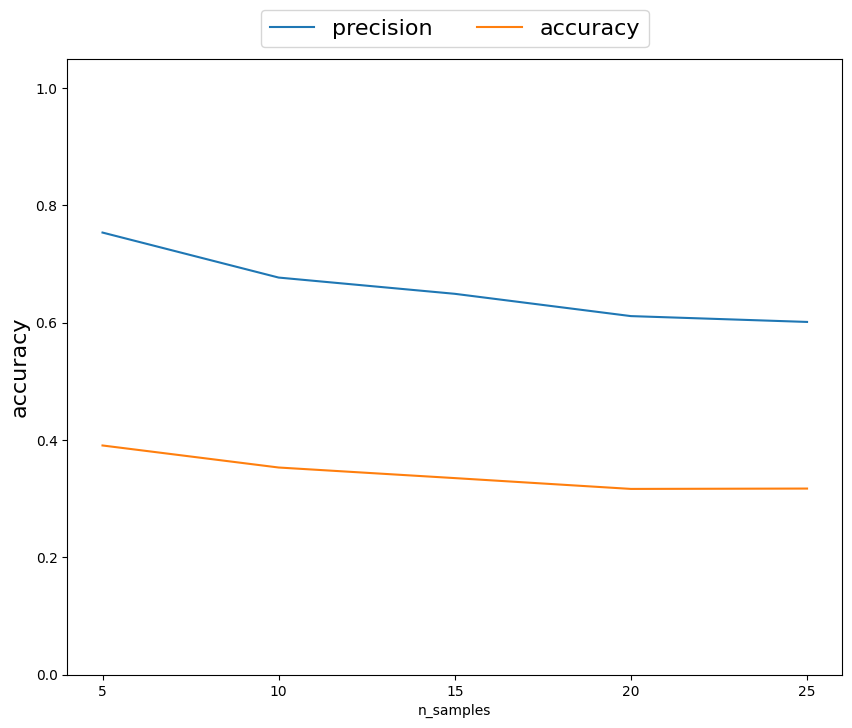

In [8]:
plot_acc_prec_summary(df_results, fontsize=16)

In [9]:
# plot accuracy and precision with df_results
# x axis: label
# y axis: accuracy/precision (average of all trials)
# group by n_sample

def plot_acc_prec_by_verification(df: DataFrame, verification="dataset", fontsize=12):
    # df_target = df.groupby(by=["strategy", "n_samples", "label"], as_index=False)
    df_target = df
    # plot
    plt.figure(figsize=(16, 8))
    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.1)
    # plt.title(f"{model} - dbpedia_14 dataset - {group_id}")
    # plt.xlabel("n_samples")
    # plt.ylim(0, 1)

    sub_acc = plt.subplot(1, 2, 1)
    # sub_acc.set_title("accuracy", fontsize=fontsize)
    sub_acc.set_xlabel("n_samples", fontsize=fontsize)
    sub_acc.set_ylabel("accuracy", fontsize=fontsize)
    sub_acc.set_ylim(0, 1.05)
    
    sub_prec = plt.subplot(1, 2, 2)
    # sub_prec.set_title("precision", fontsize=fontsize)
    sub_prec.set_xlabel("n_samples", fontsize=fontsize)
    sub_prec.set_ylabel("precision", fontsize=fontsize)
    sub_prec.set_ylim(0, 1.05)
    
    labels = []
    n_list = []
    # get average of accuracy and precision for each label group by n_sample
    for l, klass in df_target.groupby(by="label"):
        precs_by_n_sample = []
        accs_by_n_sample = []
        n_list = []
        for n_sample, data in klass.groupby(by="n_samples"):
            n_list.append(n_sample)
            precs_by_n_sample.append(data["precision"].mean())
            accs_by_n_sample.append(data["accuracy"].mean())
        sub_prec.plot(n_list, precs_by_n_sample, label=l)
        sub_acc.plot(n_list, accs_by_n_sample, label=l)
        labels.append(l)
    # plt.xticks(n_list)
    plt.legend(labels, loc="lower center", bbox_to_anchor=(0, 1), ncol=5, fontsize=fontsize)
    
    # save images
    plt.savefig(f"./plots/{group_id}/dbpedia14_{strategy}-{verification}-{ex_id}.pdf")


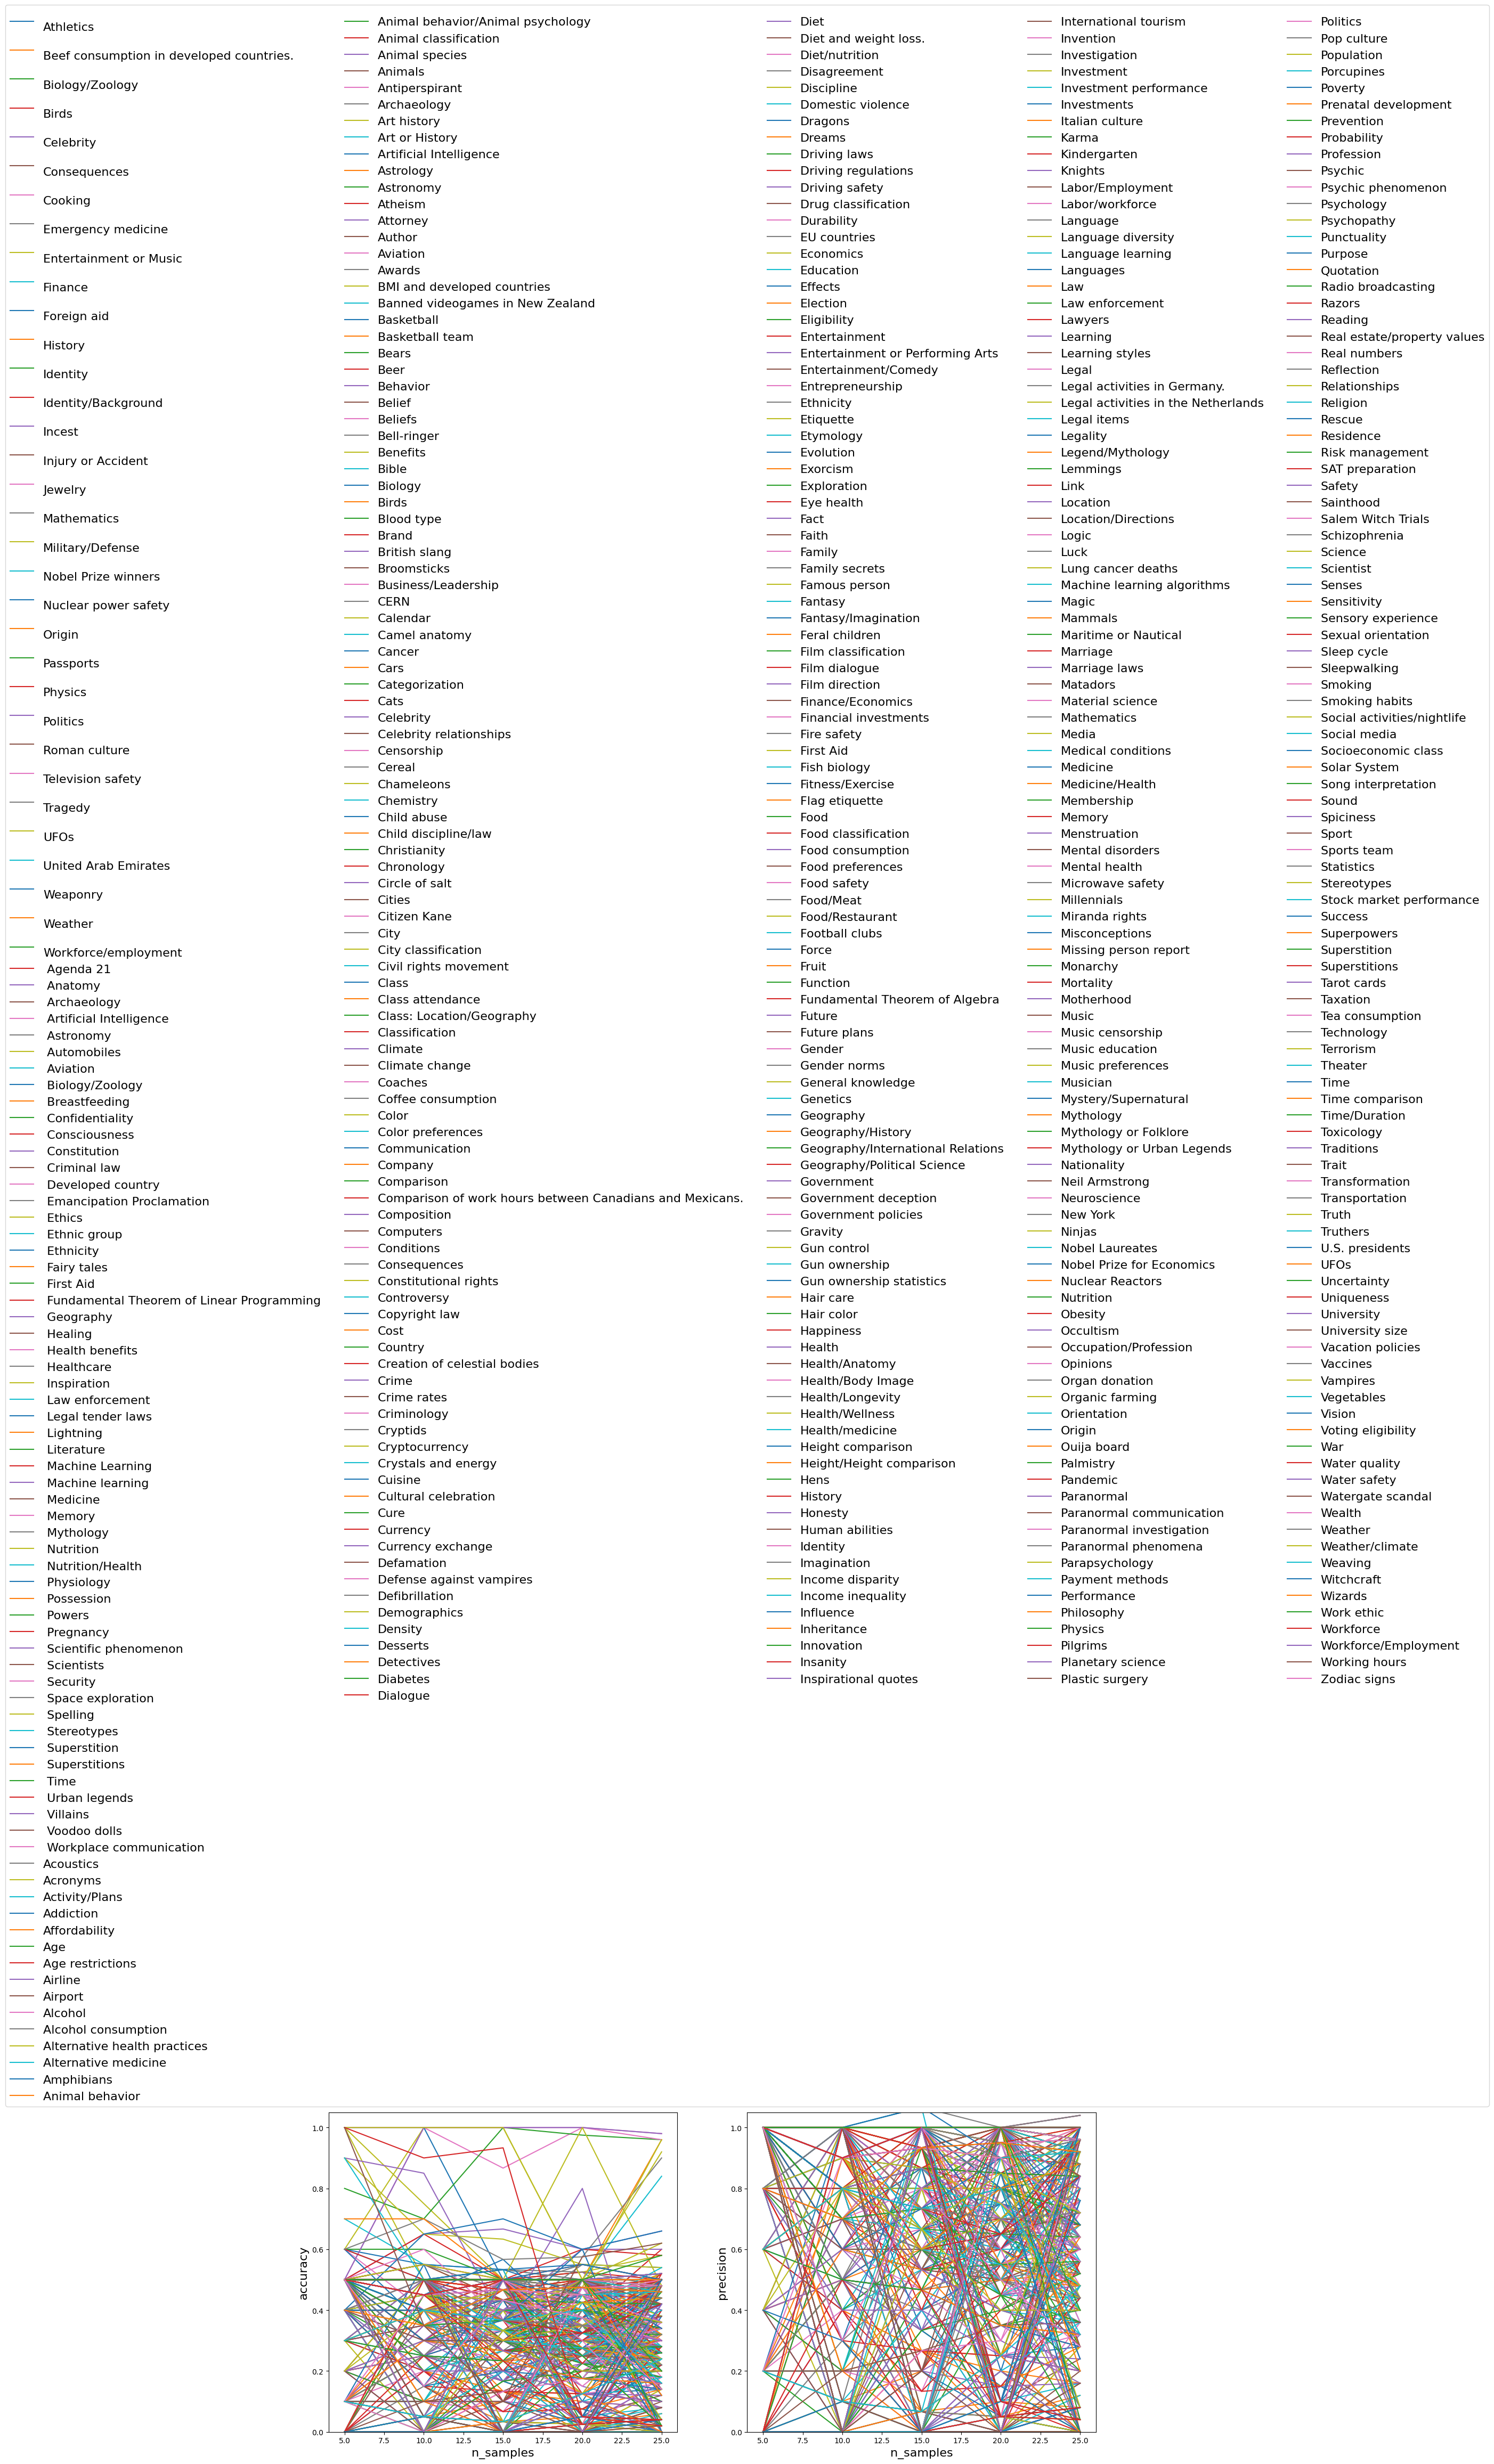

In [10]:
plot_acc_prec_by_verification(df_results, fontsize=16)